Souce: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

![Harmonic oscillator](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif "Harmonic oscillator")

# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [ ]:
import os, shutil

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from PIL import Image

In [ ]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


In [ ]:
"""
class FCN(nn.Module):
    "Defines a fully connected neural network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
"""

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

In [ ]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,8,2500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:2:1]
y_data = y[0:2:1]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [ ]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.ReLU):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        
        return outpt

In [ ]:
def plot_result(x,y,x_data,y_data,yh, i, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [ ]:
"""
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
os.makedirs("plots", exist_ok=True)

for i in range(6000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh, i)
        
#         file = "plots/nn_%.8i.png"%(i+1)
#         plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#         files.append(file)
    
        if (i+1) % 1000 == 0: plt.show()
        else: plt.close("all")
            
# save_gif_PIL("nn.gif", files, fps=20, loop=0)
"""   

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

In [ ]:
# torch.manual_seed(2022)
mu, k = 2*d, w0**2
model = FullyConnected([1, 1024, 1024, 1], activation=nn.Tanh)


In [ ]:
files = []
epochs=10000
losses = dict(dataloss=[], physicsloss=[])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

def train_oscillator():
    for fuck in [1.0, 2.0, 3.0]:
        x_physics = torch.linspace(0,fuck,200).view(-1,1).requires_grad_(True)# sample locations over the problem domain
        for i in range(epochs):
            optimizer.zero_grad()

            # compute the "data loss"
            yh = model(x_data)
            dataloss = torch.mean((yh-y_data)**2)# use mean squared error

            # compute the "physics loss"
            yhp = model(x_physics)
            dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
            dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
            physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
            physicsloss = (1e-4)*torch.mean(physics**2)

            # backpropagate joint loss
            loss = dataloss + physicsloss# add two loss terms together
            loss.backward()
            optimizer.step()
            losses["dataloss"].append(dataloss.detach().item())
            losses["physicsloss"].append(physicsloss.detach().item())
            
            # plot the result as training progresses
    #         if (i+1) % 10 == 0: 
            if (i+1) % (epochs//5) == 0: 

                yh = model(x).detach()
                xp = x_physics.detach()

                plot_result(x,y,x_data,y_data,yh, i, xp)
                plt.show()
                fig = plt.figure(figsize=(12, 4))
    #             xphysics_plot = x_physics.detach().numpy()
                plt.plot(xp, dx.detach().numpy(), label="dx")
                plt.plot(xp, dx2.detach().numpy(), label="dx2")
                plt.plot(xp, -(mu*dx + k*yhp).detach().numpy(), label="physics law")
                plt.legend()
                figs.append(fig)
    #             print(dx)
    #             print(dx2, '\n',  mu*dx + k*yhp)
                print("data physics loss", dataloss, physicsloss)
    #             file = "plots/pinn_%.8i.png"%(i+1)
    #             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    #             files.append(file)

    #             if (i+1) % 200 == 0: plt.show()
    #             else: plt.close("all")
    return losses

In [ ]:
figs=[]
losses = train_oscillator()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses["dataloss"])), losses["dataloss"], label="dataloss")
plt.plot(range(len(losses["physicsloss"])), losses["physicsloss"], label="physicsloss")
plt.legend()

In [ ]:
# !rm -rf plots
# !mkdir -p plots

## Driven oscillator
http://hyperphysics.phy-astr.gsu.edu/hbase/oscdr.html

In [69]:
def driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid):
    w0 = np.sqrt(k/m)
    gamma = c/2/m
    
    wprime = np.sqrt(w0**2 - gamma**2)
    print(f"wprime = {wprime}")
    A = F0 / m / np.sqrt((w0**2 - w**2)**2 + 4 * gamma**2 * w**2 )
    
    print(k, m, w**2)
    phi = np.arctan(c * w / (k - m * w**2)) - phid
    phih = np.arctan(wprime * (x0 - A * np.cos(phi)) \
        / (v0 + gamma * (x0 - A * np.cos(phi)) - A * w * np.sin(phi) ) )
    
    Ah = (x0 - A * np.cos(phi)) / np.sin(phih)
    
    x = Ah * np.exp(-gamma * t) * np.sin(wprime * t + phih) + A * np.cos(w * t - phi)
    
    return x


wprime = 9.9498743710662
50 0.5 99.00249999999998
torch.Size([200, 1]) torch.Size([200, 1])


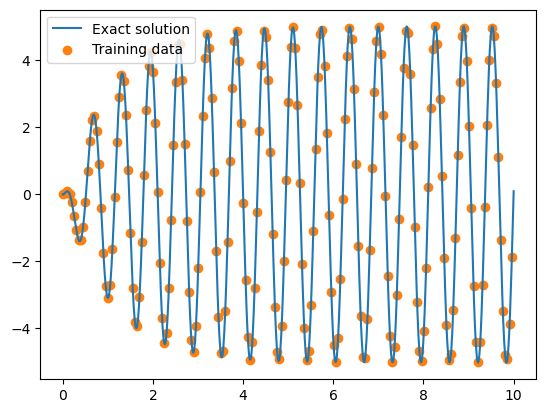

In [70]:
m = 0.5
k = 50
c = 1
w = 9.95
F0 = 50
x0 = 0
v0 = 0
phid = 1

x = torch.linspace(0,10,1000).view(-1,1)
y = driven_oscillator(x, m, k, c, w0, w, F0, x0, v0, phid)
# slice out a small number of points from the LHS of the domain
x_data = x[::5]
y_data = y[::5]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [71]:
torch.manual_seed(111)
model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
mu, k = 2*d, w0**2


In [72]:
files = []
losses = dict(dataloss=[], physicsloss=[])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

def train_driven_oscillator(epochs=100):
    for fuck in [10.0]:
        x_physics = torch.linspace(0,fuck,100).view(-1,1).requires_grad_(True)# sample locations over the problem domain
        for i in range(epochs):
            optimizer.zero_grad()

            # compute the "data loss"
            yh = model(x_data)
            dataloss = torch.mean((yh-y_data)**2)# use mean squared error

            # compute the "physics loss"
            yhp = model(x_physics)
            dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
            dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
            physics = m * dx2 + c * dx + k*yhp - F0 * torch.cos(w * x_physics + phid)# computes the residual of the 1D harmonic oscillator differential equation
            physicsloss = torch.mean(physics**2)

            # backpropagate joint loss
            loss = dataloss + physicsloss# add two loss terms together
            loss.backward()
            optimizer.step()
            
            losses["dataloss"].append(dataloss.detach().item())
            losses["physicsloss"].append(physicsloss.detach().item())

            # plot the result as training progresses
    #         if (i+1) % 10 == 0: 
            if (i+1) % (epochs//5) == 0: 

                yh = model(x).detach()
                xp = x_physics.detach()

                plot_result(x,y,x_data,y_data,yh, i, xp)
                plt.show()
                fig = plt.figure(figsize=(12, 4))
    #             xphysics_plot = x_physics.detach().numpy()
                plt.plot(xp, dx.detach().numpy(), label="dx")
    #             plt.plot(xp, dx2.detach().numpy(), label="dx2")
                plt.plot(xp, (m * dx2 + c * dx + k*yhp).detach().numpy(), label="differential left side")
                plt.plot(xp, (F0 * torch.cos(w * x_physics + phid)).detach().numpy(), label="differential right side")
                plt.legend()
                figs.append(fig)
    #             print(dx)
    #             print(dx2, '\n',  mu*dx + k*yhp)
                print("data physics loss", dataloss, physicsloss)
    #             file = "plots/pinn_%.8i.png"%(i+1)
    #             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    #             files.append(file)

    #             if (i+1) % 200 == 0: plt.show()
    #             else: plt.close("all")

    return losses

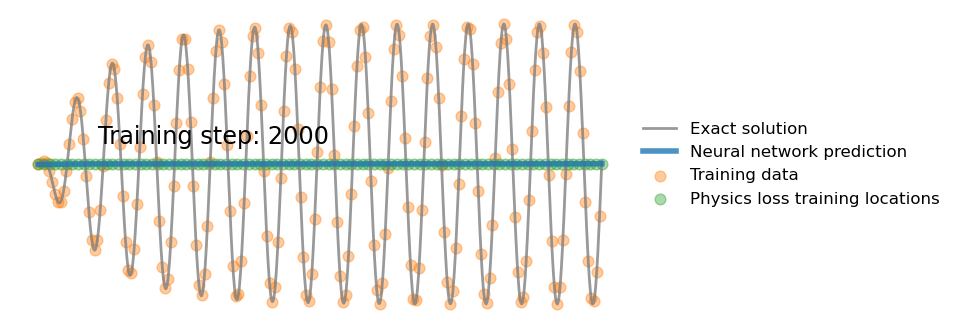

data physics loss tensor(10.6427, grad_fn=<MeanBackward0>) tensor(1247.5035, grad_fn=<MeanBackward0>)


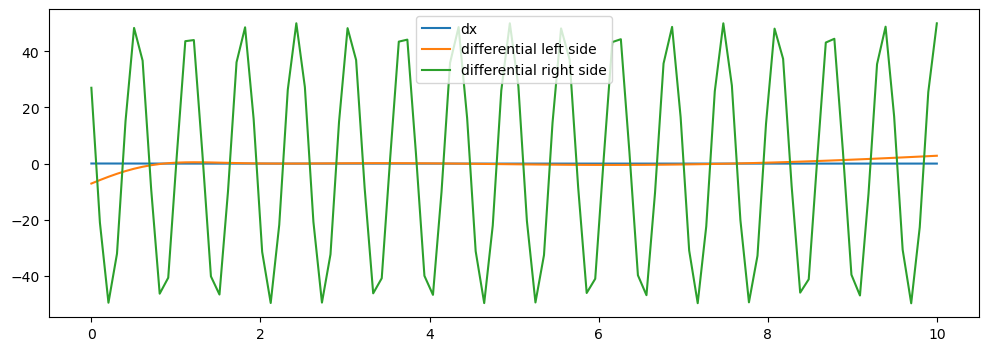

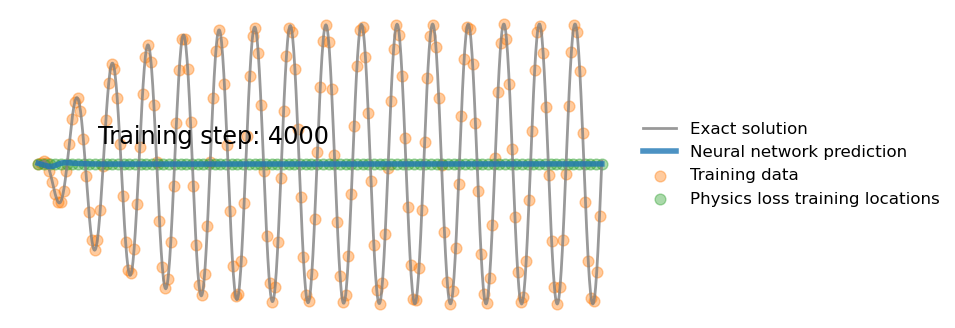

data physics loss tensor(10.6401, grad_fn=<MeanBackward0>) tensor(1197.8422, grad_fn=<MeanBackward0>)


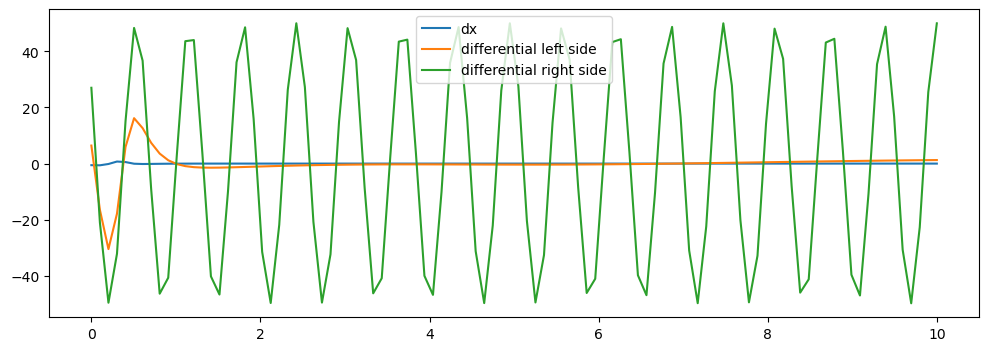

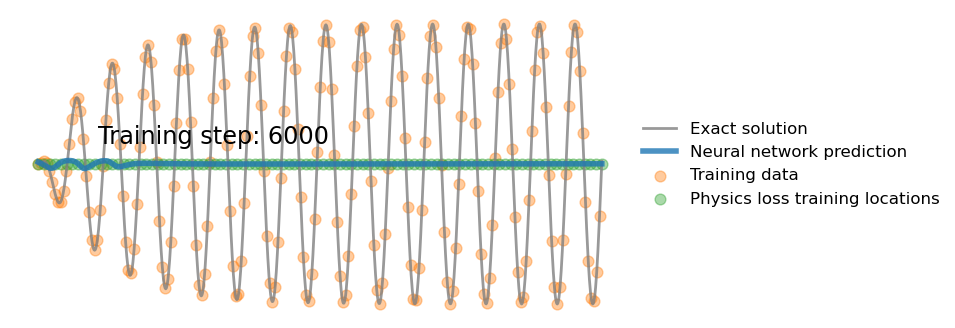

data physics loss tensor(10.6353, grad_fn=<MeanBackward0>) tensor(1054.1703, grad_fn=<MeanBackward0>)


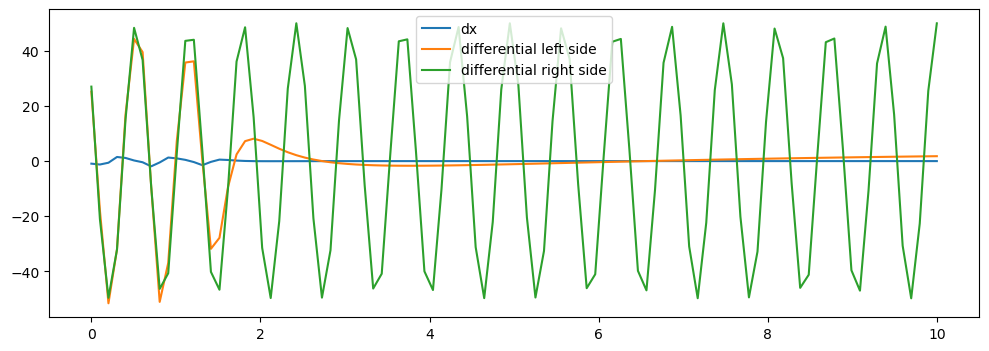

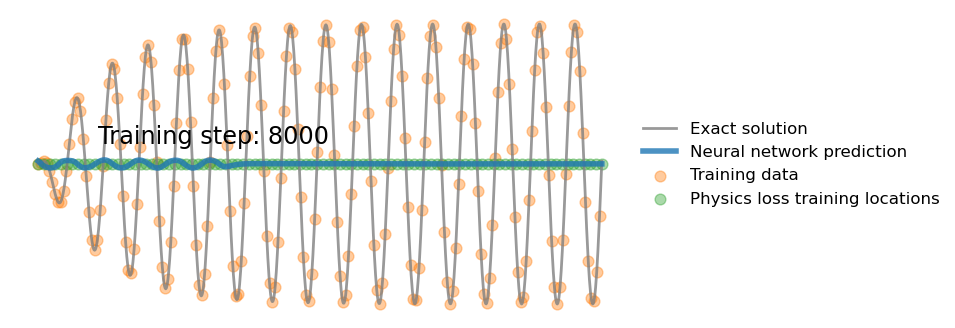

data physics loss tensor(10.6275, grad_fn=<MeanBackward0>) tensor(822.8058, grad_fn=<MeanBackward0>)


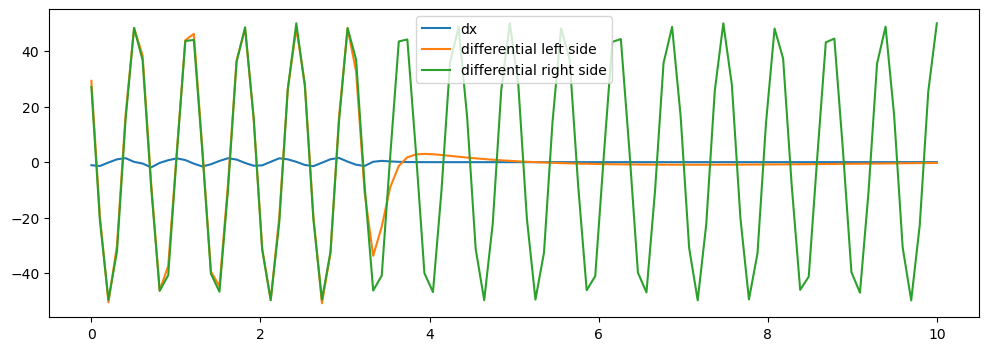

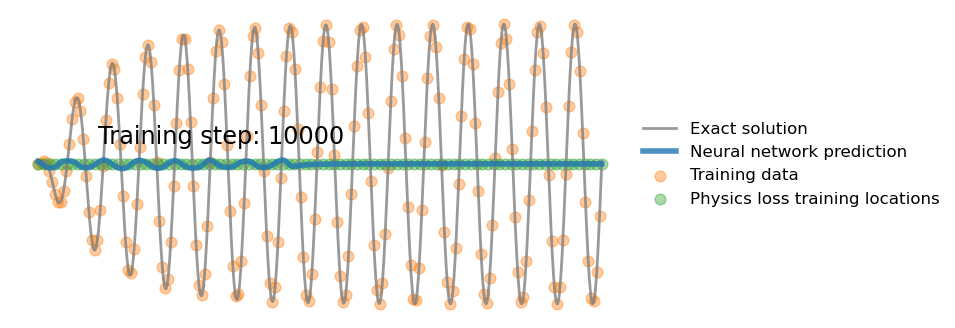

data physics loss tensor(10.6156, grad_fn=<MeanBackward0>) tensor(761.3484, grad_fn=<MeanBackward0>)


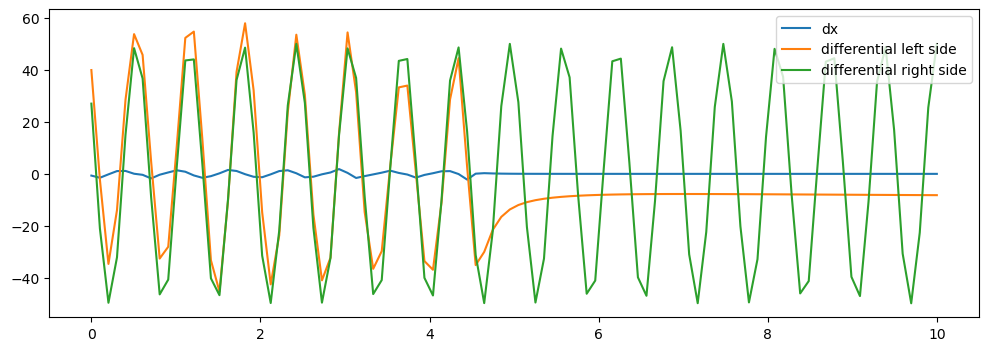

In [73]:
figs=[]
epochs=10000
losses = train_driven_oscillator(epochs)


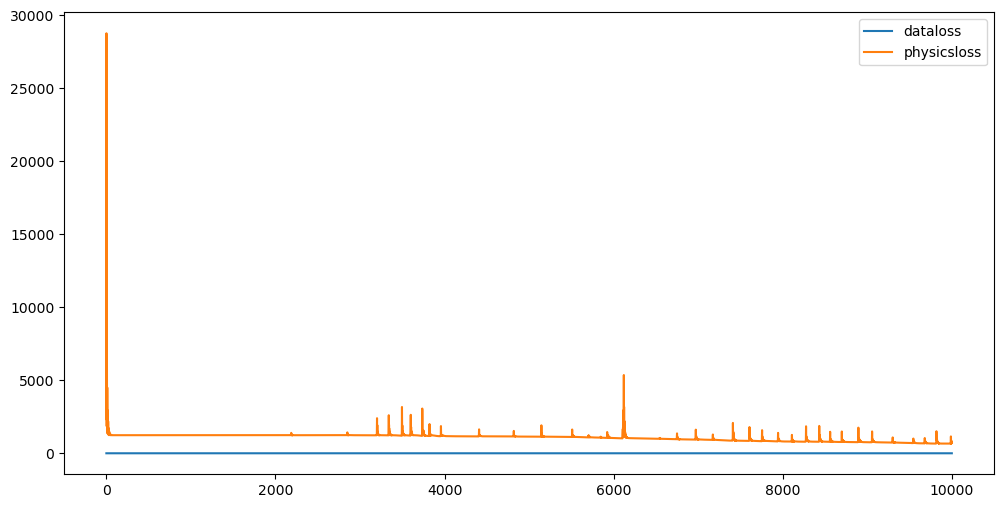

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses["dataloss"])), losses["dataloss"], label="dataloss")
plt.plot(range(len(losses["physicsloss"])), losses["physicsloss"], label="physicsloss")
plt.legend()